### Цель проекта.

Цель данного проекта - проведение предварительного анализа тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Проанализируем поведение клиентов и сделаем выводы — какой тариф лучше.

### Импортируем все необходимые библиотеки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math as mt
from scipy import stats as st
pd.options.display.max_columns = None

### Читаем csv файлы, выводим таблицы на экран

In [2]:
calls = pd.read_csv('/datasets/calls.csv')
calls.info()
calls.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [3]:
internet = pd.read_csv('/datasets/internet.csv')
internet.info()
internet.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [4]:
messages = pd.read_csv('/datasets/messages.csv')
messages.info()
messages.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [5]:
users = pd.read_csv('/datasets/users.csv')
users.info()
users.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [6]:
tariffs = pd.read_csv('/datasets/tariffs.csv')
tariffs.info()
tariffs.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


По таблице Users видим, что нам предоставлены данные 500 пользователей, в таблицах имеются пропуски и нулевые значения. Для удобства выполнения цели исследования необходимо будет обработать каждую таблицу по отдельности и объеденить в одну общую.

### Предобработка данных

Обработаем полученные таблицы. Видим, что можно таблицы 'internet','calls' и 'messages'  сгруппировать по user_id, так же логично будет выделить месяц для каждого параметра и сгруппировать данные и по месяцам, т.к оплата за предоставляемые услуги помесячная. Посчитаем для каждого пользователя:
- количество сделанных звонков и израсходованных минут разговора по месяцам;
- количество отправленных сообщений по месяцам;
- объем израсходованного интернет-трафика по месяцам;
- помесячную выручку с каждого пользователя 

#### Создадим в таблицах столбец с месяцем

In [7]:
calls['month'] = pd.DatetimeIndex(calls['call_date']).month 
internet['month'] = pd.DatetimeIndex(internet['session_date']).month
messages['month'] = pd.DatetimeIndex(messages['message_date']).month

#### Работа с таблицами

##### Звонки

Посчитаем количество звонков, и количество затраченных минут каждый месяц.

In [49]:
calls_gr=calls.groupby(['user_id', 'month'])['duration'].sum()
calls_gr_count=calls.groupby(['user_id', 'month'])['duration'].count()
calls_gr = calls_gr.reset_index(level = 'month')
calls_gr_count = calls_gr_count.reset_index(level = 'month')
calls_gr_count = calls_gr_count.rename(columns={"duration": "Number_of_calls"})
calls_gr=pd.merge(calls_gr, calls_gr_count, how = 'left', on = ['user_id','month'])
calls_gr


,month,duration,Number_of_calls
user_id,,,
1000,5,159.0,22
1000,6,172.0,43
1000,7,340.0,47
1000,8,408.0,52
1000,9,466.0,58
...,...,...,...
1498,10,247.0,41
1499,9,70.0,9
1499,10,449.0,68


In [9]:
calls_gr.describe()

,month,duration,Number_of_calls
count,3174.000000,3174.000000,3174.000000
mean,8.311594,431.250800,63.833333
std,2.910625,224.914227,32.678036
min,1.000000,0.000000,1.000000
25%,6.000000,273.835000,41.000000
50%,9.000000,420.715000,63.000000
75%,11.000000,558.602500,83.000000
max,12.000000,1578.060000,244.000000


Есть звонки, длящиеся 0.0 мин. Возможно это пропущенные звонки, т.к оператор всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута. Посчитаем количесто пропущенных звонков.

In [10]:
d=calls.loc[calls['duration']==0]['duration'].count()
print('Количество пропущенных звонков '"{:.1%}".format(d/calls.shape[0]))

Количество пропущенных звонков 19.6%


Количество пропущенных звонков почти 20%, поэтому не учитывать эти данные мы не можем. Оставим их без изменений.

Округлим значения минут в большую сторону.

In [11]:
calls['duration']=np.ceil(calls['duration'])
calls.head()

,id,call_date,duration,user_id,month
0,1000_0,2018-07-25,0.0,1000,7
1,1000_1,2018-08-17,0.0,1000,8
2,1000_2,2018-06-11,3.0,1000,6
3,1000_3,2018-09-21,14.0,1000,9
4,1000_4,2018-12-15,6.0,1000,12


#####  Интернет

Округлим значения объема интернет трафика в большую сторону.

In [12]:
internet['mb_used']=np.ceil(internet['mb_used'])

Посчитаем объем интернет трафика затраченного каждый месяц.

In [13]:
internet_gr=internet.groupby(['user_id', 'month'])['mb_used'].sum()
internet_gr = internet_gr.reset_index(level = 'month')
internet_gr.head(10)

,month,mb_used
user_id,,
1000,5,2256.0
1000,6,23257.0
1000,7,14016.0
1000,8,14070.0
1000,9,14581.0
1000,10,14717.0
1000,11,14768.0
1000,12,9827.0
1001,11,18452.0


In [14]:
internet_gr.describe()

,month,mb_used
count,3203.000000,3203.000000
mean,8.320949,17286.749610
std,2.903834,7523.580332
min,1.000000,0.000000
25%,6.000000,12543.000000
50%,9.000000,16985.000000
75%,11.000000,21455.500000
max,12.000000,49789.000000


#####  Сообщения

Посчитаем количество сообщений каждый месяц.

In [15]:
messages_gr=messages.groupby(['user_id', 'month'])['message_date'].count()
messages_gr = messages_gr.reset_index(level = 'month')
messages_gr = messages_gr.rename(columns={"message_date": "messages"})
messages_gr.head()

,month,messages
user_id,,
1000,5,22
1000,6,60
1000,7,75
1000,8,81
1000,9,57


#####  Пользователи

Изменим названия столбцов, для дальнейшего удобного использования.


In [16]:
users = users.rename(columns={"city": "city_name", "tariff": "tariff_name"}).reset_index(drop=True)
users.head()

,user_id,age,churn_date,city_name,first_name,last_name,reg_date,tariff_name
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


#### Объединяем все таблицы в одну, методом merge.

In [17]:
data=pd.merge(users, calls_gr, how = 'left', on = ['user_id'])
data=pd.merge(data, internet_gr, how = 'left', on = ['user_id','month'])
data=pd.merge(data, messages_gr, how = 'left', on = ['user_id','month'])

In [51]:
data.head()

,user_id,age,churn_date,city_name,first_name,last_name,reg_date,tariff_name,month,duration,Number_of_calls,mb_used,messages,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,profit
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,150,22,2256,22,1000,30720,3000,1950,150,1,1,1950.0
1,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,6,158,43,23257,60,1000,30720,3000,1950,150,1,1,1950.0
2,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,7,318,47,14016,75,1000,30720,3000,1950,150,1,1,1950.0
3,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,8,389,52,14070,81,1000,30720,3000,1950,150,1,1,1950.0
4,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,9,440,58,14581,57,1000,30720,3000,1950,150,1,1,1950.0


In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3182 entries, 0 to 3181
Data columns (total 13 columns):
user_id            3182 non-null int64
age                3182 non-null int64
churn_date         189 non-null object
city_name          3182 non-null object
first_name         3182 non-null object
last_name          3182 non-null object
reg_date           3182 non-null object
tariff_name        3182 non-null object
month              3174 non-null float64
duration           3174 non-null float64
Number_of_calls    3174 non-null float64
mb_used            3163 non-null float64
messages           2678 non-null float64
dtypes: float64(5), int64(2), object(6)
memory usage: 348.0+ KB


Посмотрим статистические данные получившейся таблицы.

In [20]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,3182.0,1251.620050,144.493687,1000.0,1126.000,1254.000,1378.0000,1499.00
age,3182.0,46.635449,16.575142,18.0,32.000,46.000,62.0000,75.00
month,3174.0,8.311594,2.910625,1.0,6.000,9.000,11.0000,12.00
duration,3174.0,431.250800,224.914227,0.0,273.835,420.715,558.6025,1578.06
Number_of_calls,3174.0,63.833333,32.678036,1.0,41.000,63.000,83.0000,244.00
mb_used,3163.0,17263.882074,7508.861096,0.0,12530.500,16971.000,21448.0000,49789.00
messages,2678.0,45.134802,34.431280,1.0,19.000,38.000,63.0000,224.00


Изучим таблицу на наличие пропусков

In [21]:
print("|{: <20}|".format("Столбец"),"{: <20}|".format("количество пропусков"),"{: <25}|".format("процентов от общего числа"))
print('-----------------------------------------------------------------------')
for i in data.columns:
    if data[i].isna().sum() != 0:
        print("|{: <20}|".format(i),"{: ^20}|".format(data[i].isna().sum()),"{: ^25.1%}|".format(data[i].isna().sum()/data.shape[0]))

|Столбец             | количество пропусков| процентов от общего числа|
-----------------------------------------------------------------------
|churn_date          |         2993        |           94.1%          |
|month               |          8          |           0.3%           |
|duration            |          8          |           0.3%           |
|Number_of_calls     |          8          |           0.3%           |
|mb_used             |          19         |           0.6%           |
|messages            |         504         |           15.8%          |


Удалим пропуски и изменим формат данных на int где необходимо

In [22]:
data['mb_used']=data['mb_used'].fillna(0)
data['duration']=data['duration'].fillna(0)
data['messages']=data['messages'].fillna(0)
data['Number_of_calls']=data['Number_of_calls'].fillna(0)
data['mb_used']=data['mb_used'].astype('int')
data['duration']=data['duration'].astype('int')
data['messages']=data['messages'].astype('int')
data['Number_of_calls']=data['Number_of_calls'].astype('int')
data['month']=data['month'].astype('Int64')

Посмотрим на наличие дубликатов.

In [23]:
data.duplicated().sum()

0

Посчитаем выручку с каждого абонента. Для этого добавим в таблицу параметры тарифов.

In [24]:
data=pd.merge(data, tariffs, how = 'outer', on = ['tariff_name']).reset_index(drop=True)
data.head()

,user_id,age,churn_date,city_name,first_name,last_name,reg_date,tariff_name,month,duration,Number_of_calls,mb_used,messages,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,150,22,2256,22,1000,30720,3000,1950,150,1,1
1,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,6,158,43,23257,60,1000,30720,3000,1950,150,1,1
2,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,7,318,47,14016,75,1000,30720,3000,1950,150,1,1
3,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,8,389,52,14070,81,1000,30720,3000,1950,150,1,1
4,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,9,440,58,14581,57,1000,30720,3000,1950,150,1,1


Создадим функцию расчета помесячной выручки с каждого пользователя. При подсчете оплаты за интернет трафик сверх лимита, переводим наши данные в гигабайты, так как цена указана 'рублей за гигабайт'.

In [25]:
def profit(data):
    
    extra_duration=(data['duration']-data['minutes_included'])*data['rub_per_minute']
    extra_mb_used=((data['mb_used']-data['mb_per_month_included'])/1024)*data['rub_per_gb']
    extra_messages=(data['messages']-data['messages_included'])*data['rub_per_message']

    if extra_duration < 0: extra_duration = 0
        
    if extra_mb_used < 0: extra_mb_used = 0
        
    if extra_messages < 0: extra_messages = 0
        

    profit=extra_duration+extra_mb_used+extra_messages+data['rub_monthly_fee']  
    return profit


In [26]:
data['profit']=data.apply(profit,axis=1).round(2)
data.head()

,user_id,age,churn_date,city_name,first_name,last_name,reg_date,tariff_name,month,duration,Number_of_calls,mb_used,messages,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,profit
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,150,22,2256,22,1000,30720,3000,1950,150,1,1,1950.0
1,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,6,158,43,23257,60,1000,30720,3000,1950,150,1,1,1950.0
2,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,7,318,47,14016,75,1000,30720,3000,1950,150,1,1,1950.0
3,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,8,389,52,14070,81,1000,30720,3000,1950,150,1,1,1950.0
4,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,9,440,58,14581,57,1000,30720,3000,1950,150,1,1,1950.0


###  Анализ данных.

#### Выделим пользователей тарифа ultra и smart

In [27]:
data_ultra=data.query('tariff_name == "ultra"')
data_ultra.head()

,user_id,age,churn_date,city_name,first_name,last_name,reg_date,tariff_name,month,duration,Number_of_calls,mb_used,messages,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,profit
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,150,22,2256,22,1000,30720,3000,1950,150,1,1,1950.0
1,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,6,158,43,23257,60,1000,30720,3000,1950,150,1,1,1950.0
2,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,7,318,47,14016,75,1000,30720,3000,1950,150,1,1,1950.0
3,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,8,389,52,14070,81,1000,30720,3000,1950,150,1,1,1950.0
4,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,9,440,58,14581,57,1000,30720,3000,1950,150,1,1,1950.0


Посмотрим сколько пользователей тарифа Ultra

In [28]:
data_ultra.shape[0]

957

In [29]:
data_smart=data.query('tariff_name == "smart"')
data_smart.head()

,user_id,age,churn_date,city_name,first_name,last_name,reg_date,tariff_name,month,duration,Number_of_calls,mb_used,messages,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,profit
957,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart,11,408,59,18452,0,50,15360,500,550,200,3,3,1153.91
958,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart,12,391,63,14053,0,50,15360,500,550,200,3,3,550.00
959,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,6,110,15,10871,4,50,15360,500,550,200,3,3,550.00
960,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,7,204,26,17601,11,50,15360,500,550,200,3,3,987.70
961,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,8,269,42,20347,13,50,15360,500,550,200,3,3,1524.02


Посмотрим солько пользователей тарифа Smart

In [30]:
data_smart.shape[0]

2225

#### Посчитаем среднее значение, дисперсию и стандартное отклонение.

In [31]:
desc_stat = data.pivot_table(index=['tariff_name'], values=['duration', 'mb_used', 'messages','profit'], 
                    aggfunc={'duration': [np.mean, np.var, np.std], 
                             'mb_used': [np.mean, np.var, np.std], 
                             'messages': [np.mean, np.var, np.std],
                             'profit': np.mean})
desc_stat

duration                                 mb_used                \
                   mean         std           var          mean           std   
tariff_name                                                                     
smart        394.637753  179.353829  32167.795876  16215.577978   5900.805630   
ultra        511.118077  291.750656  85118.445248  19358.409613  10220.563902   

                            messages                               profit  
                      var       mean        std          var         mean  
tariff_name                                                                
smart        3.481951e+07  33.366292  28.264460   798.879709  1200.396153  
ultra        1.044599e+08  48.726228  46.903402  2199.929154  2060.772372

Построим диаграммы размаха для тарифов.

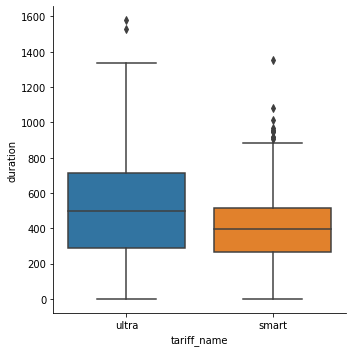

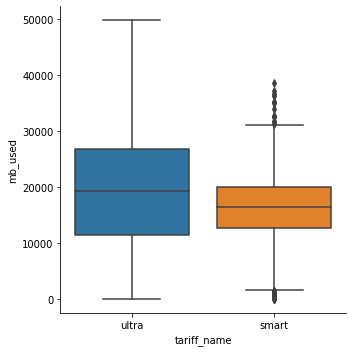

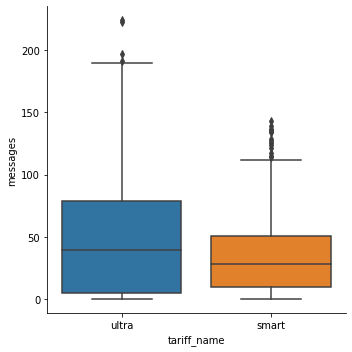

In [32]:
for column in ['duration', 'mb_used', 'messages']:    
    sns.catplot(x="tariff_name", y=column, kind="box", data=data, orient='v')

По диаграмме размаха видно, что в тарифе Smart намного больше выбросов по всем параметрам.

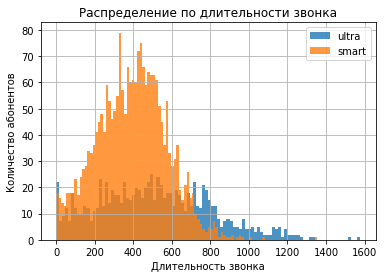

In [33]:
data_ultra['duration'].hist(bins=100,alpha=0.8)
data_smart['duration'].hist(bins=100,alpha=0.8)
plt.title('Распределение по длительности звонка')
plt.xlabel('Длительность звонка')
plt.ylabel('Количество абонентов')
_ = plt.legend(['ultra', 'smart'])
plt.show()

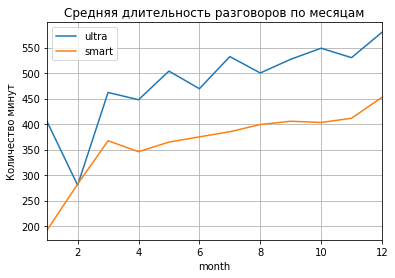

In [34]:
data_ultra_mean = data_ultra.groupby('month')['duration'].mean()
data_smart_mean = data_smart.groupby('month')['duration'].mean()
data_ultra_mean.plot(x='month', y ='duration',legend=True,grid = True)
data_smart_mean.plot(x='month', y ='duration',title = 'Средняя длительность разговоров по месяцам',legend=True,grid = True)
plt.ylabel('Количество минут')
_ = plt.legend(['ultra', 'smart'])
plt.show()

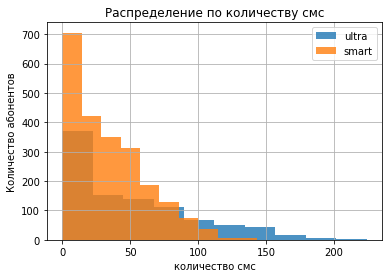

In [35]:
data_ultra['messages'].hist(alpha=0.8)
data_smart['messages'].hist(alpha=0.8)
plt.title('Распределение по количеству смс')
plt.xlabel('количество смс')
plt.ylabel('Количество абонентов')
_ = plt.legend(['ultra', 'smart'])
plt.show()

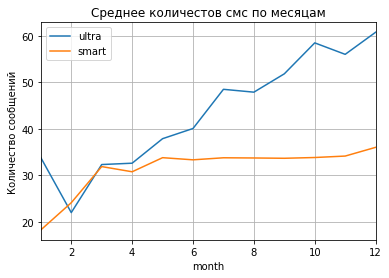

In [36]:
data_ultra_mean = data_ultra.groupby('month')['messages'].mean()
data_smart_mean = data_smart.groupby('month')['messages'].mean()
data_ultra_mean.plot(x='month', y ='messages',legend=True,grid = True)
data_smart_mean.plot(x='month', y ='messages',title = 'Среднее количестов смс по месяцам',legend=True,grid = True)
plt.ylabel('Количество сообщений')
_ = plt.legend(['ultra', 'smart'])
plt.show()

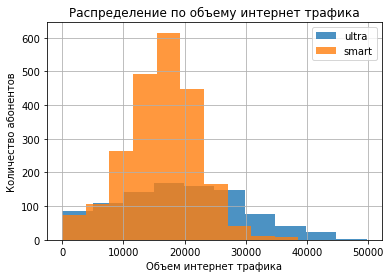

In [37]:
data_ultra['mb_used'].hist(alpha=0.8)
data_smart['mb_used'].hist(alpha=0.8)
plt.title('Распределение по объему интернет трафика')
plt.xlabel('Объем интернет трафика')
plt.ylabel('Количество абонентов')
_ = plt.legend(['ultra', 'smart'])
plt.show()

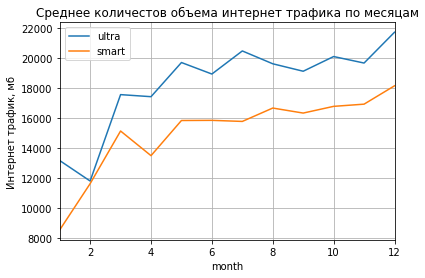

In [38]:
data_ultra_mean = data_ultra.groupby('month')['mb_used'].mean()
data_smart_mean = data_smart.groupby('month')['mb_used'].mean()
data_ultra_mean.plot(x='month', y ='mb_used',legend=True,grid = True)
data_smart_mean.plot(x='month', y ='mb_used',title = 'Среднее количестов объема интернет трафика по месяцам',grid = True)
plt.ylabel('Интернет трафик, мб')
_ = plt.legend(['ultra', 'smart'])
plt.show()

По гистограммам видно, что дисперсия по тарифу Smart меньше, чем у пользователей  Ultra по всем показателям: по длительности разговора, числу сообщений и использованному интернет-трафику. Также наблюдаем тенденцию по обоим тарифам на увеличение количества используемых минут, трафика интернета и отправленных сообщений в течение года.

### Проверка гипотез

#### Гипотиза №1. Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается

За нулевую гипотезу принимаем равенство средних значений выручек таифов Ultra и Smart
Альтенативная гипотиза, что средняя выручка пользователей тарифов Ultra и Smart различаются

Найдем средние значения выручки пользователей тарифов «Ультра» и «Смарт».

In [39]:
print('Средняя выручка с тарифа Ultra ','{:.2f}'.format(data_ultra['profit'].mean()))
print('Средняя выручка с тарифа Smart ','{:.2f}'.format(data_smart['profit'].mean()))

Средняя выручка с тарифа Ultra  2060.77
Средняя выручка с тарифа Smart  1200.40


Проверим гипотезу, используя встроенную в библиотеку scipy функцию ttest_ind - которая вычисляет уровень значимости критерия Стьюдента для двух независимых выборок.Зададим степень свободы 1, т.к. работаем с выборками из генеральной совокупности.

In [40]:
sample_1=data_ultra['profit']
sample_2=data_smart['profit']
alpha = 0.01
results = st.ttest_ind(
    sample_1, 
    sample_2,
    equal_var=False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 2.956884e-318
Отвергаем нулевую гипотезу


Полученное значение p-value говорит о том, что средние выручки пользователей тарифов не равны. Средние значения выручки по тарифам различаются почти в 2 раза. Также видим, что средняя выручка тарифа Smart в 2 раза выше ежемесячной платы по тарифу. Это говорит о том, что пользователи Smart часто не укладываются в рамки тарифа.

#### Гипотиза №2.  Cредняя выручка пользователей из Москвы равна средней выручке пользователей из других регионов.

Нулевая гипотеза - средняя выручка от пользователей из Москвы равна средней выручке пользователей других городов.

Альтернативная гипотеза - средние выручки пользователей из Москвы и пользователей других регионов отличаются.

Выделим пользователей из Москвы и других регионов.

In [41]:
user_moscow=data.query('city_name == "Москва"')
user_moscow.head()

,user_id,age,churn_date,city_name,first_name,last_name,reg_date,tariff_name,month,duration,Number_of_calls,mb_used,messages,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,profit
8,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra,8,355,55,8571,37,1000,30720,3000,1950,150,1,1,1950.0
9,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra,9,904,134,12479,91,1000,30720,3000,1950,150,1,1,1950.0
10,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra,10,809,108,14779,83,1000,30720,3000,1950,150,1,1,1950.0
11,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra,11,775,115,11368,94,1000,30720,3000,1950,150,1,1,1950.0
12,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra,12,755,108,10132,75,1000,30720,3000,1950,150,1,1,1950.0


Посчитаем количество пользователей в Москве

In [42]:
user_moscow.shape[0]

610

In [43]:
user_no_moscow=data.query('city_name != "Москва"')
user_no_moscow.head()

,user_id,age,churn_date,city_name,first_name,last_name,reg_date,tariff_name,month,duration,Number_of_calls,mb_used,messages,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,profit
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,150,22,2256,22,1000,30720,3000,1950,150,1,1,1950.0
1,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,6,158,43,23257,60,1000,30720,3000,1950,150,1,1,1950.0
2,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,7,318,47,14016,75,1000,30720,3000,1950,150,1,1,1950.0
3,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,8,389,52,14070,81,1000,30720,3000,1950,150,1,1,1950.0
4,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,9,440,58,14581,57,1000,30720,3000,1950,150,1,1,1950.0


Посчитаем количество пользователей в других регионах

In [44]:
user_no_moscow.shape[0]

2572

In [45]:
print('Средняя выручка в Москве ','{:.2f}'.format(user_moscow['profit'].mean()))
print('Средняя выручка в других регионах ','{:.2f}'.format(user_no_moscow['profit'].mean()))

Средняя выручка в Москве  1486.11
Средняя выручка в других регионах  1452.77


Аналогично предыдущему примеру вычислим уровень значимости.

In [46]:
sample_1=user_moscow['profit']
sample_2=user_no_moscow['profit']
alpha = 0.01
results = st.ttest_ind(
    sample_1, 
    sample_2)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 0.34274352375689765
Не получилось отвергнуть нулевую гипотезу


Полученное значение p-value не дает возможности отвергать исходную гипотезу о том, что доходы от пользователей из Москвы и из других регионов равны. Средняя выручка в Москве практически не отличаются от выручки в других регионах.
Если бы мы отклонили нулевую гипотезу мы бы с вероятностью 34,2% ошиблись.

### Общий вывод

- Целью данного исследования было проведение предварительного анализа тарифов и определение какой из тарифов лучше. 
- Входные данные — данные 500 пользователей «Мегалайна» за 2018год.
- В процессе предобработки данных мы сгруппировали данные в таблицах по месяцам и id пользователей,после чего объединили все данные в общую таблицу. 
- Избавились от пропусков в столбцах влияющих на исследование
- Изменили типы данных на корректные в столбцах, учавствующих в исследовании
- Расчитали ежемесячную прибыль для всех пользователей
- При анализе данных нашли сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц. Посчитали среднее количество, дисперсию и стандартное отклонение.
- Для оценки мы использовали уровень значимости критерия Стьюдента для независимых выборок, т.к. средние выручки выборок не зависят друг от друга.
- По результатам статистического анализа средняя выручка от тарифа Ultra больше, чем от тарифа Smart: 2060 рублей и 1200рублей соответственно. По среднему доходу можно увидеть, что пользователи Ultra намого реже выходят за рамки своего тарифа, чем пользователи Smart. 
- Также наблюдаем тенденцию по обоим тарифам на увеличение количества используемых минут, трафика интернета и отправленных сообщений в течение года.
- Пользователей в Москве в 4 раза меньше, чем в других регионах.Средние доходы от пользователей в Москве не отличаются от доходов в других регионах: 1486 рублей и 1452 рублей соответственно. Статистический анализ не позволил опровергнуть гипотезу о равенсте средних доходов.
- Исходя из среднего дохода по тарифам можно сделать вывод, что тариф Ultra, более выгодный тариф для «Мегалайна», но и от тарифа Smart тоже нельзя отказываться,т.к пользователей этого тарифа больше чем в 2 раза и отказавшись, мы потеряем большое количество пользователей. В связи с тем, что пользователи Smart часто не укладываются в рамки тарифа, можно предлагать им переход на тариф Ultra, тем самым увеличить доходы «Мегалайна».